# Notebook to run differential expression analysis on CMC using ´MAST´ - Mdx

**Created by** : **Srivalli Kolla**

**Devloped on** : 31 October,2024 

**Last Modified** : 31 October,2024 

**Institute of Systems Immunology, University of Wurzburg**

Env : mast_env

# Importing packages

In [1]:
import os
import numpy as np
import anndata
import datetime
import scanpy as sc
import pandas as pd
import sc_toolbox
import scipy.io
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.sparse as sparse


from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import r

pandas2ri.activate()

MAST = importr('MAST')


Installed version 0.12.1 of sc-toolbox is outdated. Newest version is 0.12.3!

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 300, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

timestamp = datetime.datetime.now().strftime("%d_%m_%y,%H:%M")
timestamp

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 8.2.0
adjustText          1.2.0
argcomplete         NA
attr                23.2.0
backcall            0.2.0
backports           NA
backports_abc       NA
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
cloudpickle         2.2.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dask                2022.02.0
dateutil            2.9.0
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
fsspec              2023.1.0
h5py                3.7.0
ipykernel           6.16.2
ipython_genutils    0.2.0
jedi                0.19.1
jinja2              3.1.4
joblib              1.3.2
kiwisolver          1.4.4
llvmlite            0.39.1
markupsafe          2.1.5
matplotlib          3.5.3
more_itertools      NA
mpl_toolkits        NA
natsort             8.4.0
nbinom_ufunc        NA
numba               0.56.3
numpy               1.21.6
packaging           23.2
panda

'31_10_24,16:13'

# MAST

## Data Preparation

##### Steps followed

1. Data loading and subsetting
2. Normalization and log transformation
3. Generating individual files for genes, barcodes, metadata and a matrix having log counts

In [3]:
files = ['../data/dmd_annotated_human_wt_cmc_1k_hvg_25_10_24,11:40.h5ad','../data/dmd_annotated_wt_others_cmc_5k_hvg_25_10_24,11:49.h5ad']

adatas = [anndata.read_h5ad(fp) for fp in files]

adata = anndata.concat(adatas, join='inner')
adata

AnnData object with n_obs × n_vars = 84692 × 29378
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    obsm: 'X_pca', 'X_umap'
    layers: 

In [4]:
desired_cell_state = ['vCM1', 'vCM2', 'vCM3', 'vCM4']
adata = adata[adata.obs['cell_state'].isin(desired_cell_state)]
adata

View of AnnData object with n_obs × n_vars = 84690 × 29378
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    obsm: 'X_pca', 'X_umap'
    

In [5]:
adata = adata[adata.obs['genotype'] == 'Mdx']
adata

View of AnnData object with n_obs × n_vars = 3090 × 29378
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    obsm: 'X_pca', 'X_umap'
    l

In [6]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

X_is_raw(adata)

False

In [7]:
sparse_matrix = sparse.csr_matrix(adata.X.T)
scipy.io.mmwrite(f'./DE_results/de_matrix_Mdx_{timestamp}.mtx', sparse_matrix)
genes = pd.DataFrame(adata.var.index, columns=["gene"])
genes.to_csv(f'./DE_results/de_genes_Mdx_{timestamp}.tsv', sep='\t', index=False, header=False)
barcodes = pd.DataFrame(adata.obs.index, columns=["barcode"])
barcodes.to_csv(f'./DE_results/de_barcodes_Mdx_{timestamp}.tsv', sep='\t', index=False, header=False)
metadata = adata.obs
metadata.to_csv(f'./DE_results/de_metadata_Mdx_{timestamp}.tsv', sep='\t', index=True, header=True)

In [8]:
adata.obs['cell_state'].value_counts()

vCM1    2770
vCM3     180
vCM4     140
Name: cell_state, dtype: int64

In [9]:
adata

View of AnnData object with n_obs × n_vars = 3090 × 29378
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase', 'C_scANVI'
    obsm: 'X_pca', 'X_umap'
    l

## Defining Functions

##### Steps followed in defining functions

*Create_single_cell_assay*

For creating a single cell assay object which can be used by MAST for differential gene expression

1. Read the matrix, genes, and barcodes files
2. Ensure the matrix has correct row and column names by checking with colnames and riownames of matrix
3. Convert sparse matrix to dense matrix
4. Ensure metadata matches the expression matrix
5. Create the SingleCellAssay object
6. Compute number of expressed genes per cell and store as a column in sca object
7. Store columns of interest as factors
8. Create the SingleCellAssay object

In [11]:
def create_single_cell_assay():
    print("Creating SingleCellAssay object...")
    robjects.r('''
    library(MAST)
    library(Matrix)
    
        exprsMatrix <- readMM("./DE_results/de_matrix_Mdx_31_10_24,16:13.mtx")
        genes <- read.table("./DE_results/de_genes_Mdx_31_10_24,16:13.tsv", header=FALSE, stringsAsFactors=FALSE)
        barcodes <- read.table("./DE_results/de_barcodes_Mdx_31_10_24,16:13.tsv", header=FALSE, stringsAsFactors=FALSE)
        metadata <- read.table("./DE_results/de_metadata_Mdx_31_10_24,16:13.tsv", header=TRUE, sep="\t", row.names=1, stringsAsFactors=FALSE) 


    colnames(exprsMatrix) <- barcodes$V1
    rownames(exprsMatrix) <- genes$V1

    exprsMatrix <- as.matrix(exprsMatrix)

    common_cells <- intersect(colnames(exprsMatrix), rownames(metadata))
    exprsMatrix <- exprsMatrix[, common_cells]
    metadata <- metadata[common_cells, ]

    sca <- FromMatrix(exprsArray=exprsMatrix,
                      cData=metadata,
                      fData=data.frame(gene_id=rownames(exprsMatrix)),
                      class="SingleCellAssay",
                      check_sanity=FALSE)

    cdr2 <- colSums(assay(sca) > 0)
    colData(sca)$n_genes_per_cell <- scale(cdr2)

    colData(sca)$genotype <- factor(colData(sca)$genotype)
    colData(sca)$cell_state <- factor(colData(sca)$cell_state)

    sca
    ''')
    print("SingleCellAssay object created.")
    return robjects.r['sca']


sca = create_single_cell_assay()


Creating SingleCellAssay object...


SingleCellAssay object created.


##### Steps followed in defining functions

*Find_de_MAST*

For performing differential gene expression analysis

1. Define and fit the model by considering n_genes_per_cell and genotype and 
2. Perform likelihood-ratio test for the condition of interest
3. Extract datatable from summary with log-fold changes and p-values
4. Crea te a list to store results generated in next steps
5. For each gene in a cellstate , extract log fold change using natural basic logarithm and p-value and FDR and store temporarily in alist with defined column and cellstate
6. Convert the coefficients to log2 base
7. False discovery rate calculation (Multiple testing correction)
8. Call the R function 'find_de' for dsifferential expression analysis and run on sca object

In [12]:
def find_de_MAST(sca):
    print("Finding differentially expressed genes...")
    robjects.r('''
    library(MAST)
    library(data.table)
    
    find_de <- function(sca) {
    zlmCond <- zlm(~ n_genes_per_cell + cell_state, sca)
    summaryCond <- summary(zlmCond, doLRT = TRUE)
    summaryDt <- summaryCond$datatable
    
    results <- list()
    
    cell_state <- unique(summaryDt[component == 'H', contrast])
    
    for (cell_state in cell_state) {
        if (cell_state != 'n_genes_per_cell'){
            cell_state_lfc <- summaryDt[contrast == cell_state & component == 'logFC', .(primerid, coef)]
            cell_state_p <- summaryDt[contrast == cell_state & component == 'H', .(primerid, `Pr(>Chisq)`)]
            tmp <- merge(cell_state_lfc, cell_state_p, by='primerid')
            tmp$log_fold_change <- tmp$coef / log(2)
            tmp$FDR <- p.adjust(tmp$`Pr(>Chisq)`, 'fdr')
            tmp$cell_state <- cell_state
            
            # Remove extra columns if any before renaming
            tmp <- tmp[, .(primerid, log_fold_change, `Pr(>Chisq)`, FDR, cell_state)]
                
            colnames(tmp) <- c('gene_id', 'log_fold_change', 'p_value', 'FDR', 'cell_state')

            
            results[[cell_state]] <- tmp
        }
     }

        results <- lapply(results, na.omit)
        return(results)
    }
    ''')

    print("Differentially expressed genes found.")

    result = robjects.r['find_de'](sca)
    return result

de_results = find_de_MAST(sca)


Attaching package: ‘data.table’



    shift



    shift



    shift



    first, second




Finding differentially expressed genes...
Differentially expressed genes found.


Done!





Done!


Done!


Done!



## Writing files

##### Steps followed 

1. Convert the results to a pandas DataFrame
2. Savinng separate files for each cell state and a siungle file withh all results
3. Adding MAST results to anndata and writing a new anndata file

In [15]:
DE_results_df = {cell_state: pandas2ri.rpy2py_dataframe(df) for cell_state, df in de_results.items()}

all_gene_ids = set()
for df in DE_results_df.values():
    all_gene_ids.update(df['gene_id'])

for cell_state, df in DE_results_df.items():
    missing_genes = all_gene_ids - set(df['gene_id'])
    for gene in missing_genes:

        df = df.append({'gene_id': gene, 'log_fold_change': np.nan, 'p_value': np.nan, 'FDR': np.nan}, ignore_index=True)

    DE_results_df[cell_state] = df.sort_values('gene_id').reset_index(drop=True)


timestamp = pd.Timestamp.now().strftime("%d_%m_%Y,%H:%M")
for cell_state, df in DE_results_df.items():
    file_name = f"./DE_results/DE_Mdx_{cell_state}_{timestamp}.txt"
    df.to_csv(file_name, sep='\t', index=False)
    print(f"Saved DE results for {cell_state} to {file_name}")

all_results = pd.concat(DE_results_df.values(), keys=DE_results_df.keys())


try:
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        all_results,
        groupby="cell_state",
        gene_id_col='gene_id',
        score_col='log_fold_change',
        pval_col='p_value',
        pval_adj_col="FDR",
        lfc_col='log_fold_change',
        key_added='MAST_results'
    )
except ValueError as e:
    print(f"Error updating AnnData: {e}")


for col in adata.obs.columns:
    if adata.obs[col].dtype not in ['object', 'string_']:  
        adata.obs[col] = adata.obs[col].astype(str)


adata.write_h5ad(f'./DE_results/dmd_de_cmc_mdx_{timestamp}.h5ad')

print("Updated AnnData object:")
print(adata)

Saved DE results for cell_statevCM3 to ./DE_results/DE_Mdx_cell_statevCM3_31_10_2024,16:32.txt
Saved DE results for cell_statevCM4 to ./DE_results/DE_Mdx_cell_statevCM4_31_10_2024,16:32.txt
Error updating AnnData: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 14425 and the array at index 1 has size 11274
Updated AnnData object:
AnnData object with n_obs × n_vars = 3090 × 29378
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency

##### Steps followed 

1. Set thresholds
2. Define a function
3. Extracting MAST results into a dataframe and ensuring it has required columns
4. Set index to gene names
5. Filter based on thresholds and extract genes
6. Create a output directory if doesnt exist
7. Plot heatmap for each cellstate by subsetting to desired cellstate

In [16]:
adata.uns['MAST_results']

{'cell_statevCM3':       gene_id  log_fold_change       p_value           FDR      cell_state
 1        A1bg        -0.186105  4.165162e-02  1.253474e-01  cell_statevCM3
 2      A4galt         0.331865  4.511897e-13  2.802336e-11  cell_statevCM3
 3        Aaas         0.068716  2.449067e-02  8.121535e-02  cell_statevCM3
 4        Aacs        -0.044278  2.242085e-01  4.972294e-01  cell_statevCM3
 5       Aagab        -0.260202  1.686076e-01  3.922516e-01  cell_statevCM3
 ...       ...              ...           ...           ...             ...
 14421  Zyg11a         0.051346  3.888668e-01  7.851294e-01  cell_statevCM3
 14422  Zyg11b        -0.890748  2.164462e-03  1.068698e-02  cell_statevCM3
 14423     Zyx         0.456068  1.074966e-05  1.275974e-04  cell_statevCM3
 14424   Zzef1        -0.693163  2.077610e-04  1.525519e-03  cell_statevCM3
 14425    Zzz3        -0.081165  1.442780e-02  5.182930e-02  cell_statevCM3
 
 [14425 rows x 5 columns],
 'cell_statevCM4':       gene_id  log_fol

## Data visualization

No results found for group: vCM1
Plotting heatmap for group: vCM4


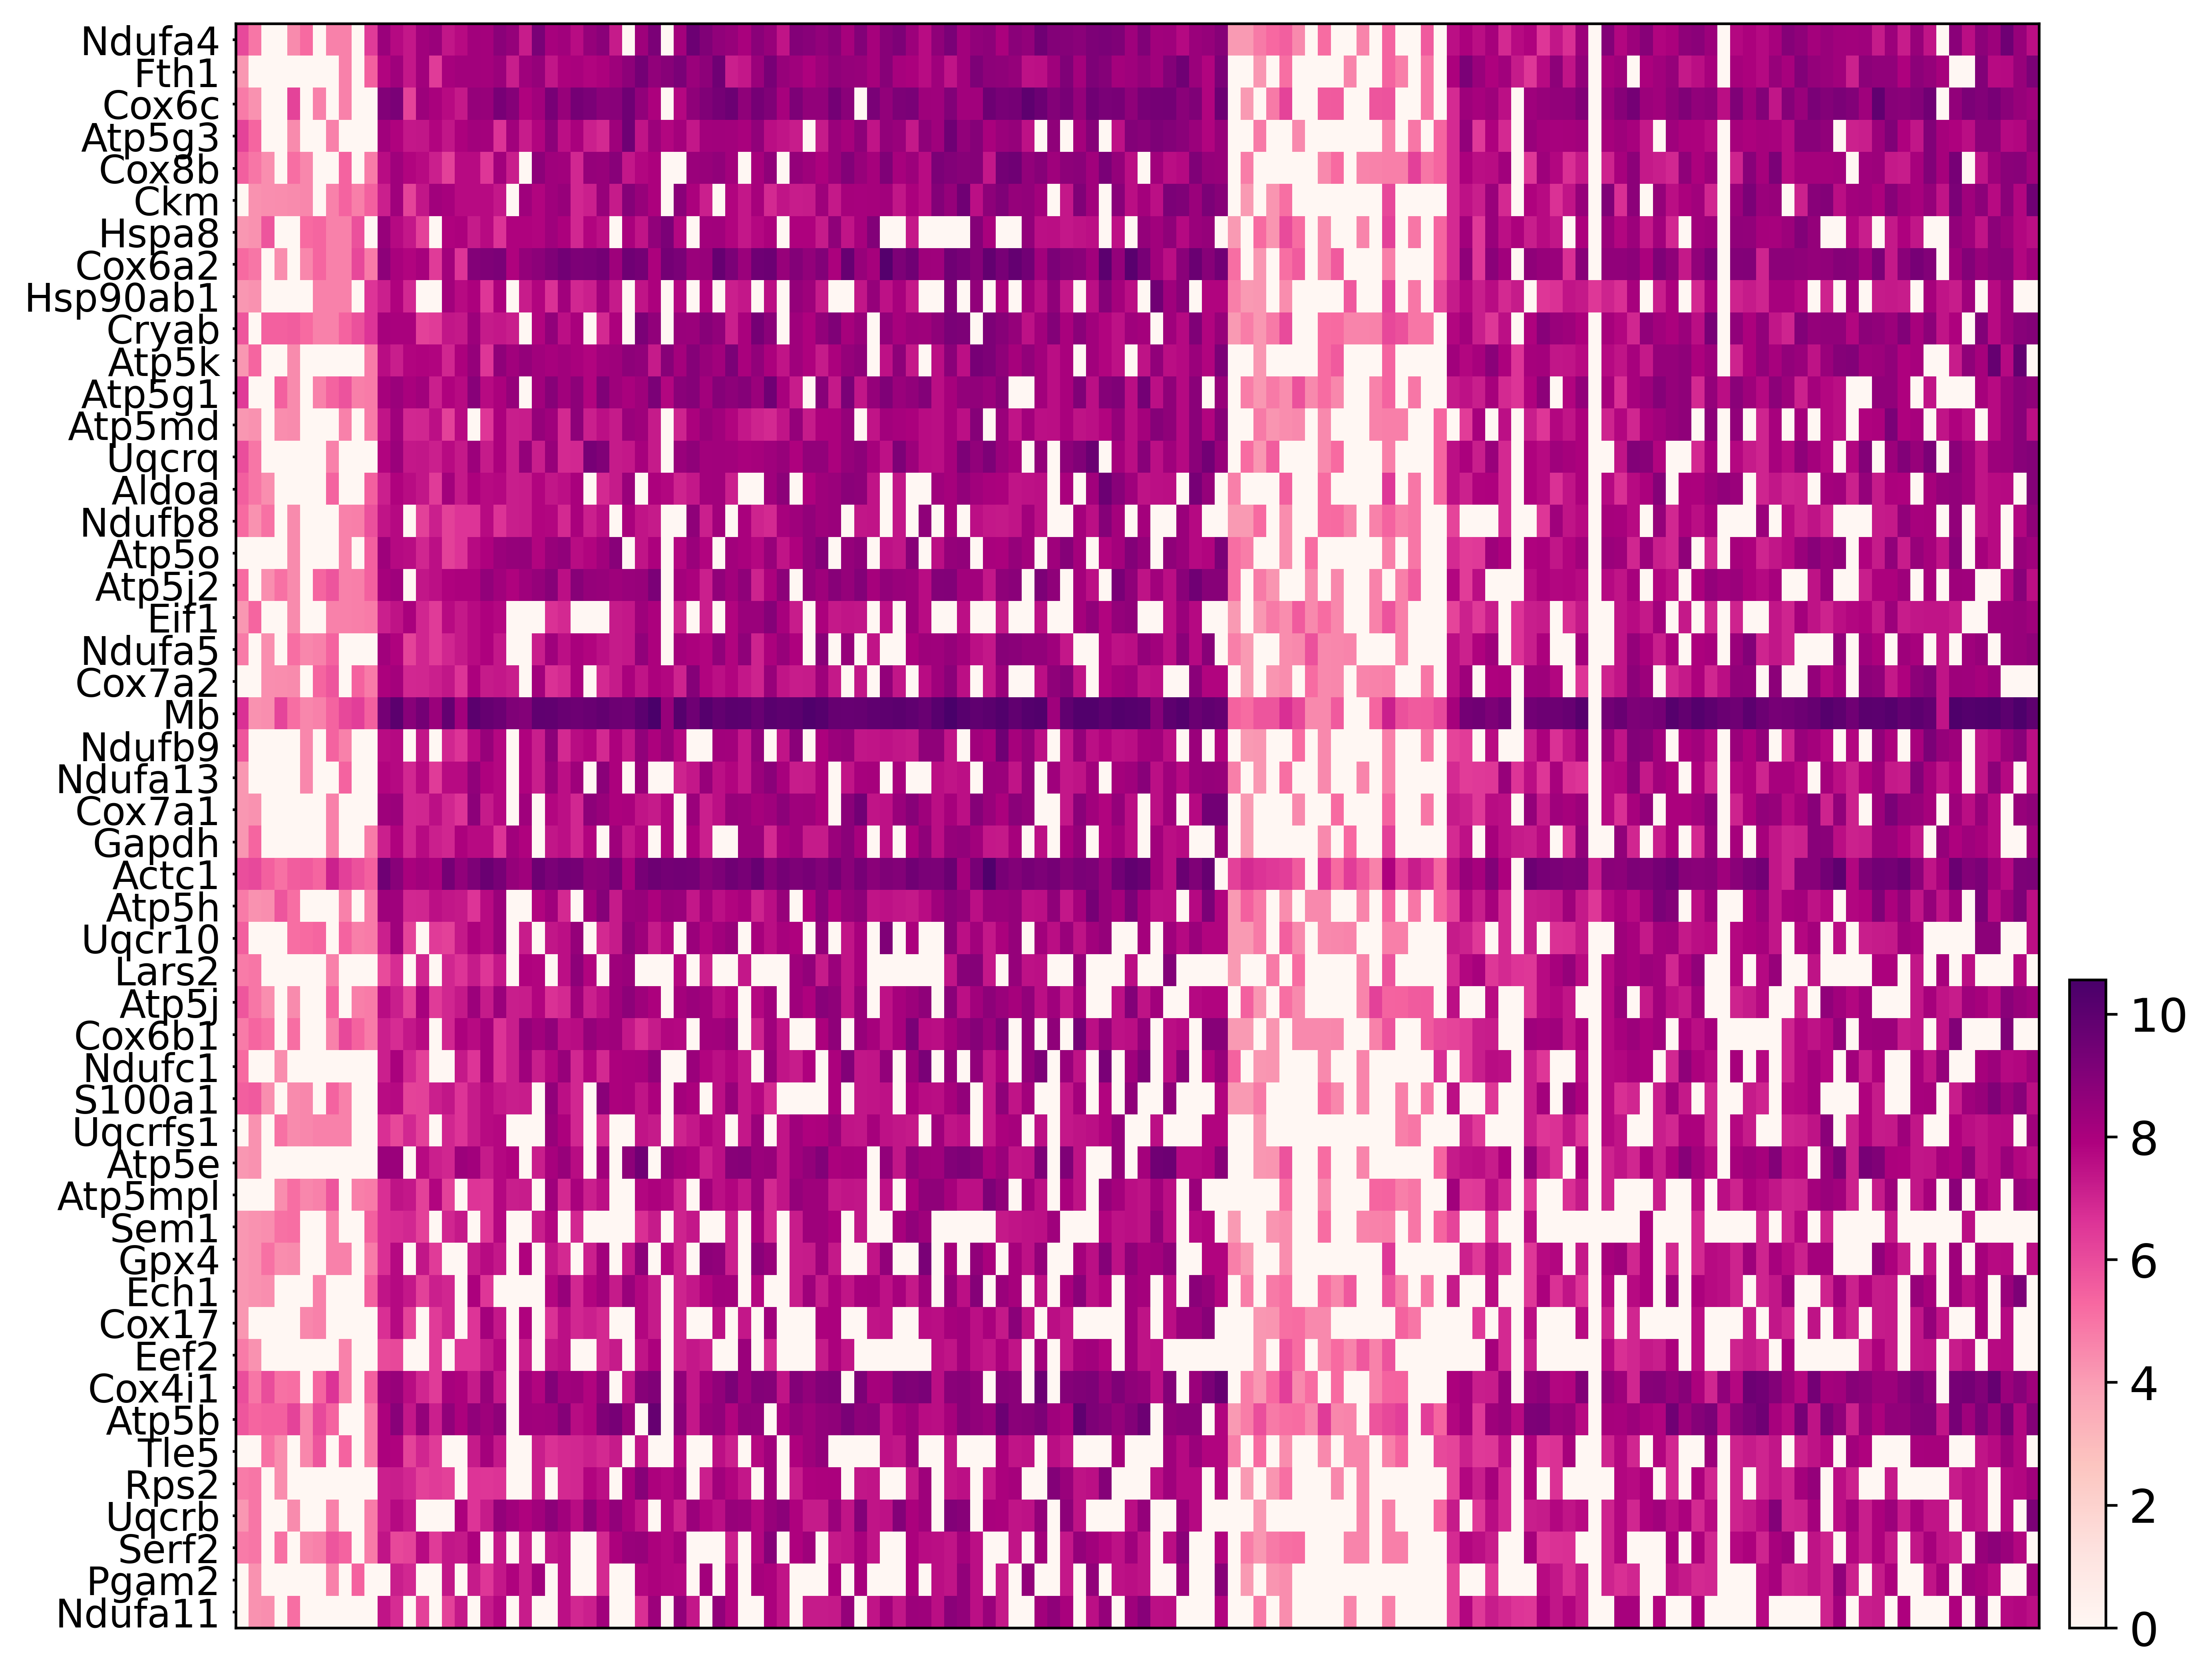

Heatmap saved to plots/DE_genes_vCM4_Mdx_heatmap_31_10_2024,16:32.png
Plotting heatmap for group: vCM3


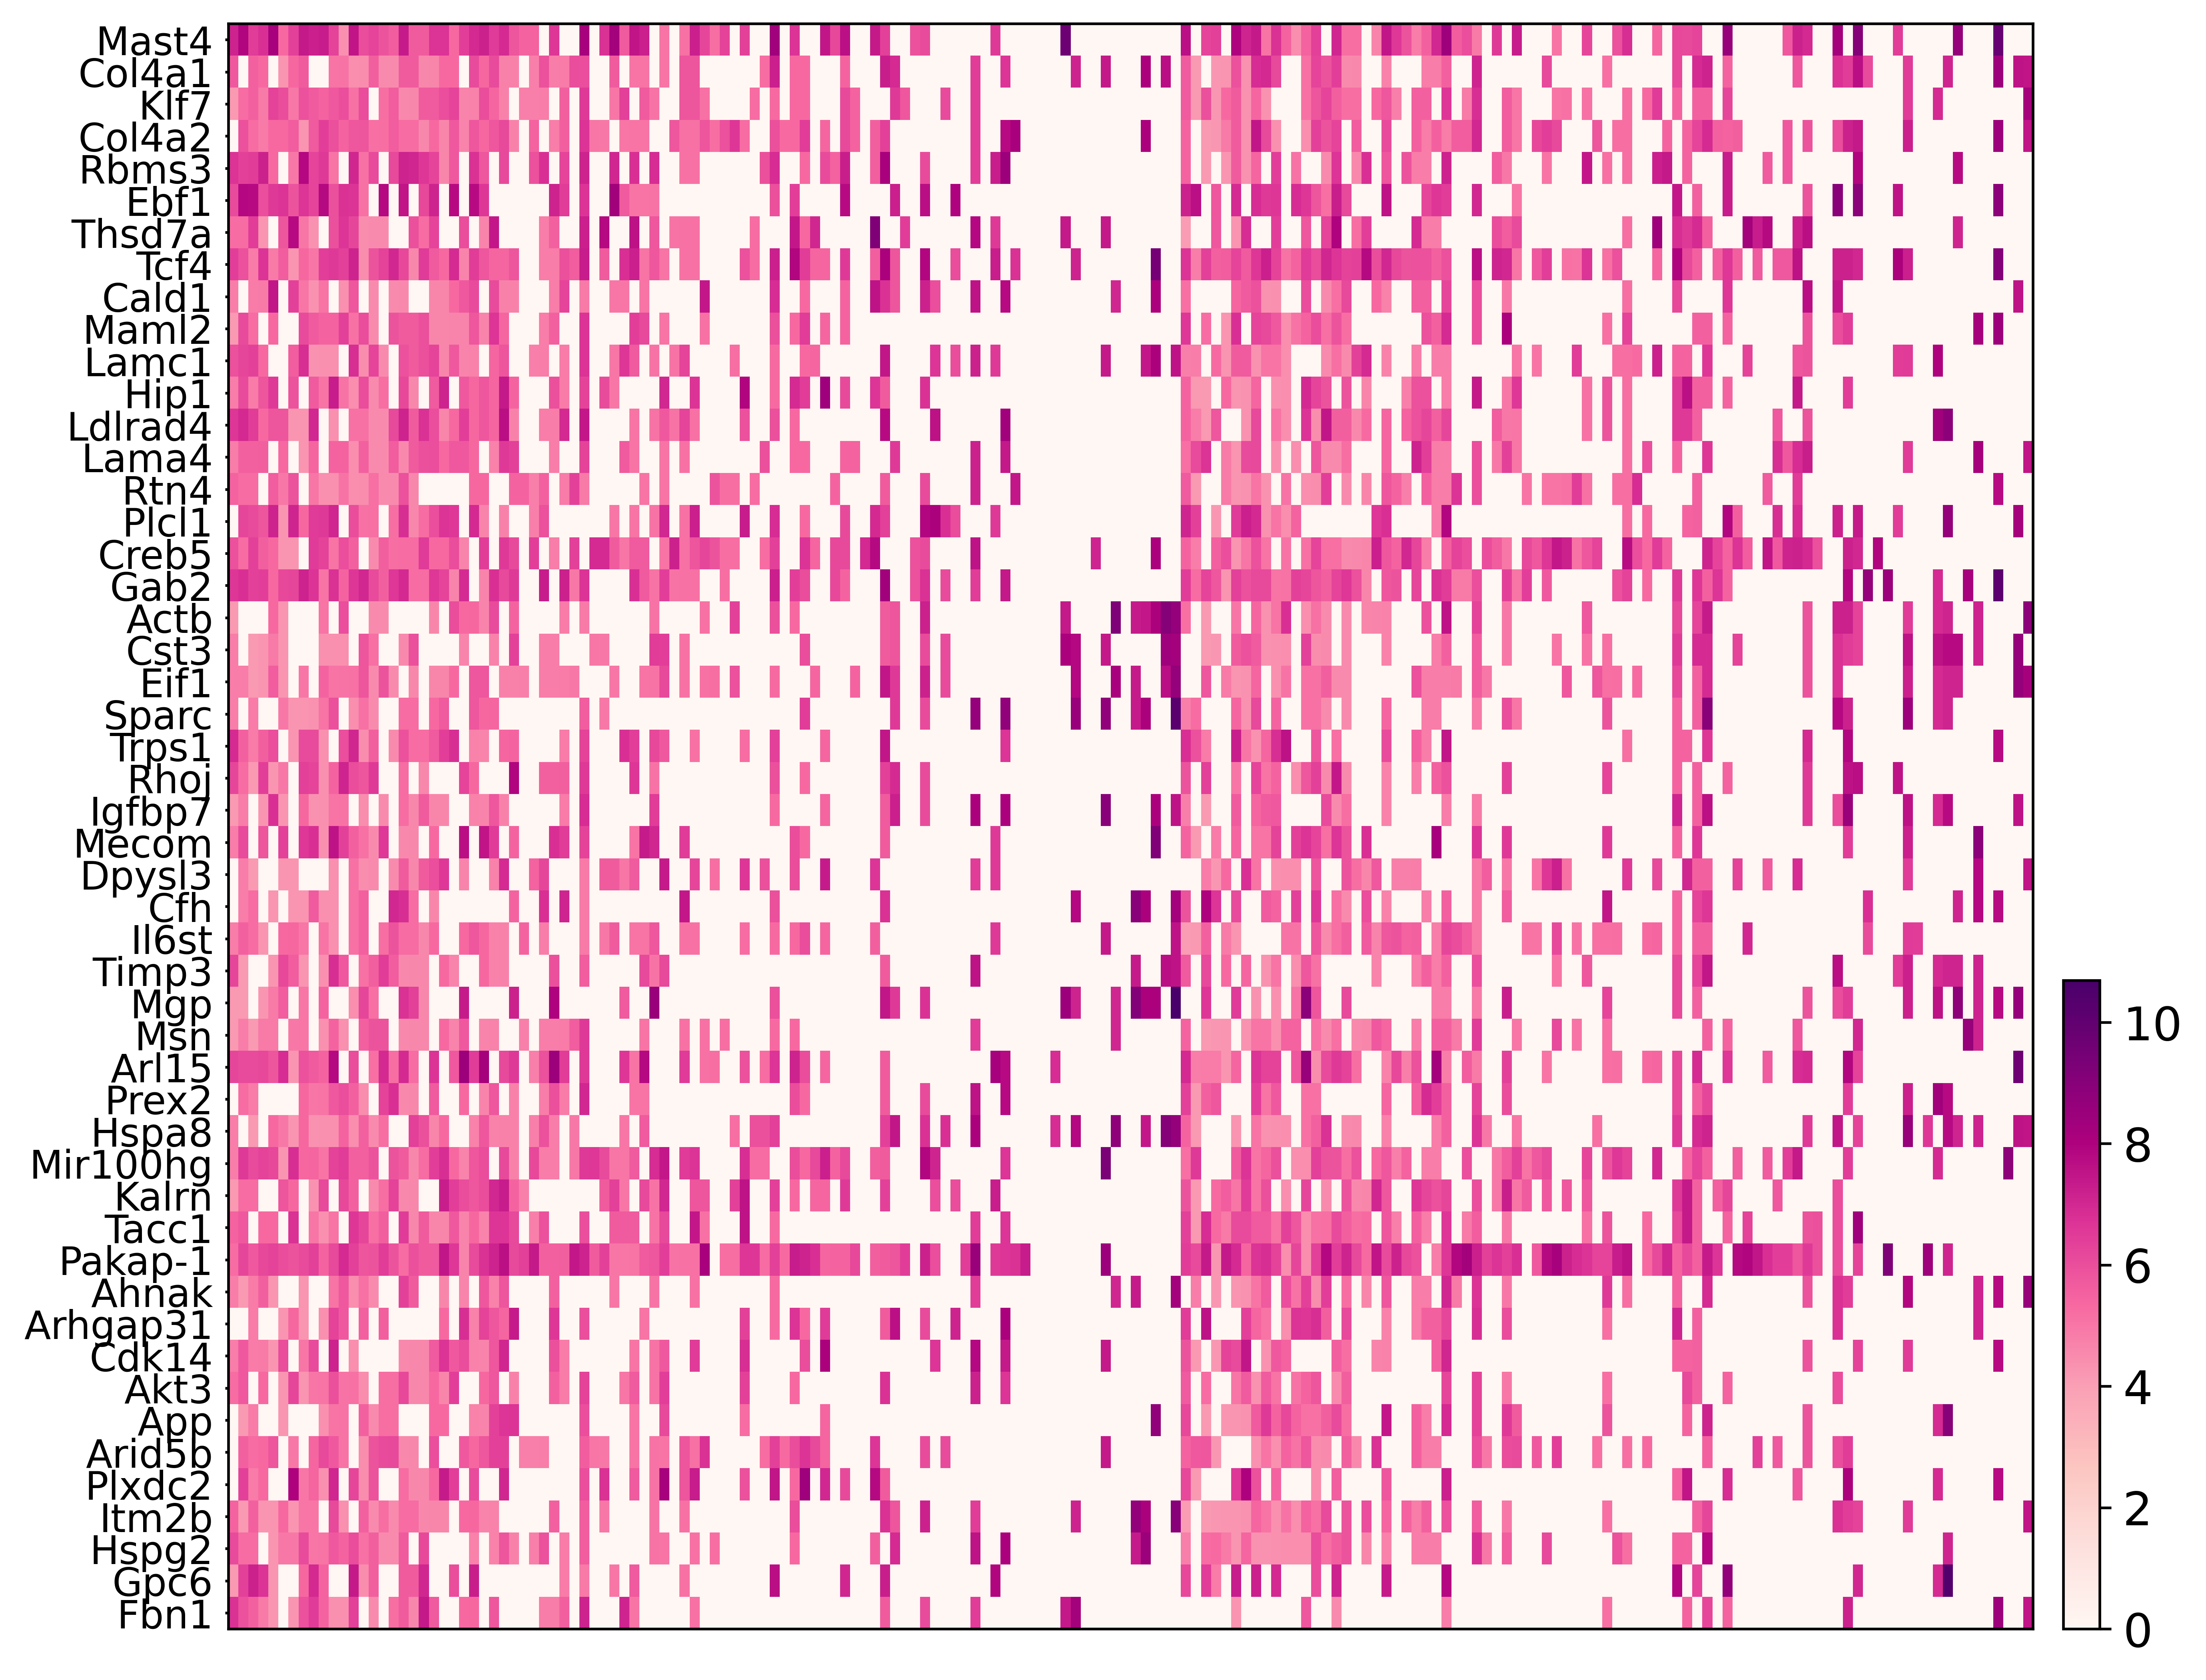

Heatmap saved to plots/DE_genes_vCM3_Mdx_heatmap_31_10_2024,16:32.png


In [17]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.5
TOP_N_GENES = 50

def plot_heatmap(adata, group_key, groupby="cell_state", output_dir="./figures/plots"):
    if group_key not in adata.uns:
        raise ValueError(f"Group key '{group_key}' not found in adata.uns")
    
    DE_results_dict = adata.uns[group_key]

    if isinstance(DE_results_dict, dict) and all(isinstance(v, pd.DataFrame) for v in DE_results_dict.values()):

        res = pd.concat(DE_results_dict.values(), keys=DE_results_dict.keys(), names=['cell_state', 'index'])
    else:
        raise ValueError(f"Unexpected format for differential expression results in adata.uns['{group_key}']")
    
    required_columns = ['gene_id', 'log_fold_change', 'p_value', 'FDR']
    for col in required_columns:
        if col not in res.columns:
            raise KeyError(f"Expected column '{col}' not found in differential expression results.")
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    unique_groups = adata.obs[groupby].unique()

    for group in unique_groups:
        group_key_full = f'cell_state{group}'
        
        if group_key_full not in DE_results_dict:
            print(f"No results found for group: {group}")
            continue

        print(f"Plotting heatmap for group: {group}")
        
        group_res = DE_results_dict[group_key_full]
        
        filtered_res = group_res[
            (group_res["FDR"] < FDR) & (abs(group_res["log_fold_change"]) > LOG_FOLD_CHANGE)
        ].sort_values(by=["log_fold_change"], ascending=False)

        top_genes = filtered_res.head(TOP_N_GENES)
        
        markers = list(top_genes['gene_id'].unique())

        if len(markers) == 0:
            print(f"No significant genes found for group: {group}")
            continue
        
        adata_group = adata[adata.obs[groupby] == group].copy()
        adata_group = adata_group[:, adata_group.var_names.isin(markers)]

        filename = f"DE_genes_{group}_Mdx_heatmap_{timestamp}.png"
        filepath = os.path.join(output_dir, filename)

        sc.pl.heatmap(
            adata_group,
            var_names=markers,
            groupby=groupby,
            swap_axes=True,
            show=True,
        )
        
        plt.title(f"Heatmap - {group}_Mdx")
        plt.ylabel("Gene Names") 
        plt.savefig(filepath)
        print(f"Heatmap saved to {filepath}")
        plt.close()


plot_heatmap(adata, group_key="MAST_results")

No results found for group: vCM1
Plotting dot plot for group: vCM4


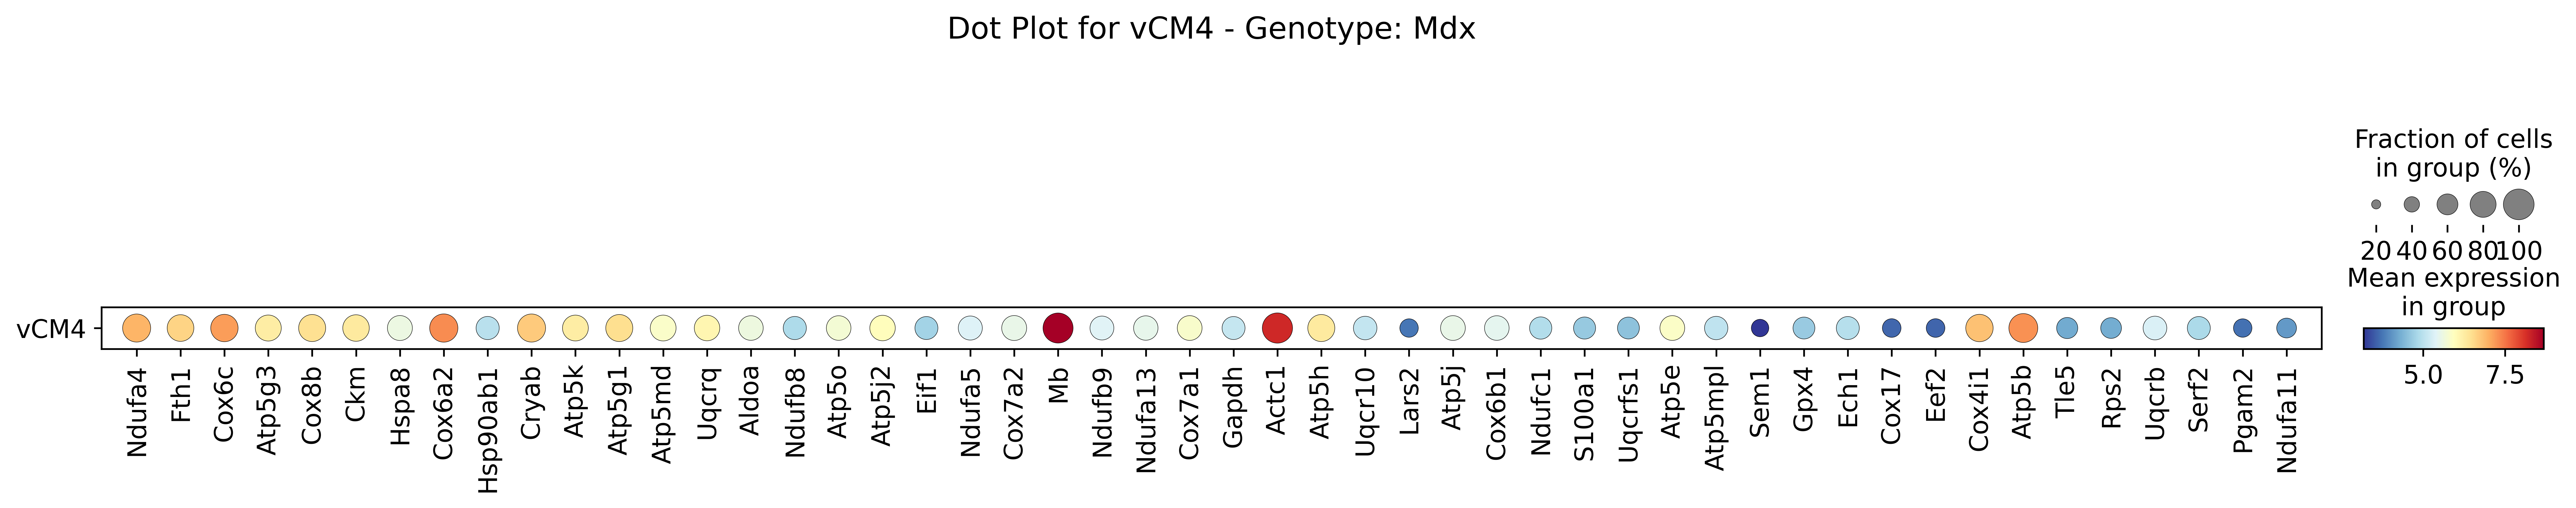

Dot plot saved to plots/Mdx_vCM4_dotplot_31_10_2024,16:32.png
Plotting dot plot for group: vCM3


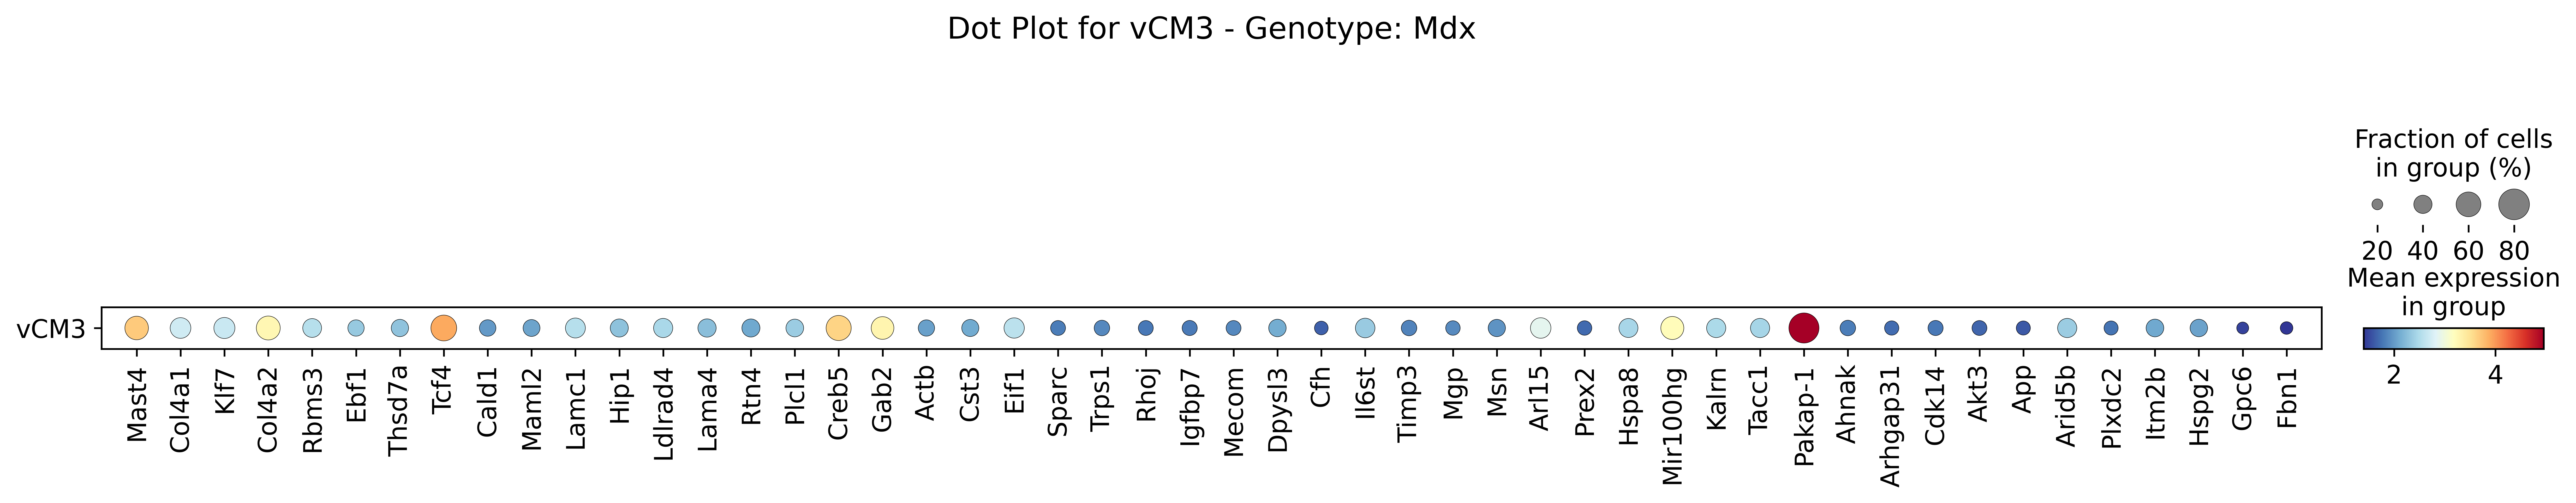

Dot plot saved to plots/Mdx_vCM3_dotplot_31_10_2024,16:32.png


In [19]:
FDR = 0.01
LOG_FOLD_CHANGE = 1.0
TOP_N_GENES = 50

def plot_dotplot(adata, group_key, genotype_key, groupby="cell_state", output_dir="plots"):
    if group_key not in adata.uns:
        raise ValueError(f"Group key '{group_key}' not found in adata.uns")
    
    if genotype_key not in adata.obs:
        raise ValueError(f"Genotype key '{genotype_key}' not found in adata.obs")
    
    DE_results_dict = adata.uns[group_key]

    if isinstance(DE_results_dict, dict) and all(isinstance(v, pd.DataFrame) for v in DE_results_dict.values()):
        res = pd.concat(DE_results_dict.values(), keys=DE_results_dict.keys(), names=['cell_state', 'index'])
    else:
        raise ValueError(f"Unexpected format for differential expression results in adata.uns['{group_key}']")
    
    required_columns = ['gene_id', 'log_fold_change', 'p_value', 'FDR']
    for col in required_columns:
        if col not in res.columns:
            raise KeyError(f"Expected column '{col}' not found in differential expression results.")
    
    
    unique_groups = adata.obs[groupby].unique()

    for group in unique_groups:
        group_key_full = f'cell_state{group}'
        
        if group_key_full not in DE_results_dict:
            print(f"No results found for group: {group}")
            continue

        print(f"Plotting dot plot for group: {group}")
        
        group_res = DE_results_dict[group_key_full]
        
        filtered_res = group_res[
            (group_res["FDR"] < FDR) & (abs(group_res["log_fold_change"]) > LOG_FOLD_CHANGE)
        ].sort_values(by=["log_fold_change"], ascending=False)
        
        top_genes = filtered_res.head(TOP_N_GENES)
        markers = list(top_genes['gene_id'].unique())
        if len(markers) == 0:
            print(f"No significant genes found for group: {group}")
            continue
        
        adata_group = adata[adata.obs[groupby] == group].copy()
        
        genotypes = adata_group.obs[genotype_key].unique()
        if len(genotypes) > 0:
            genotype = genotypes[0]
            title = f"Dot Plot for {group} - Genotype: {genotype}"
        else:
            title = f"Dot Plot for {group}"
        
        filename = f"Mdx_{group}_dotplot_{timestamp}.png"
        filepath = os.path.join(output_dir, filename)

        os.makedirs(os.path.dirname(filepath), exist_ok=True)

        sc.pl.dotplot(
            adata_group,
            var_names=markers,
            groupby=groupby,
            cmap="RdYlBu_r",
            title=title,
            show=True,
            save=filepath
        )
        
        print(f"Dot plot saved to {filepath}")
        plt.close()


plot_dotplot(adata, group_key="MAST_results", genotype_key="genotype")


## Checking vcm1 DE

In [20]:
adata.obs['cell_state'].value_counts

<bound method IndexOpsMixin.value_counts of GCTCAAATCCGCAACG-1-query-query    vCM1
CAGGCCATCCGACGGT-1-query-query    vCM1
TCCTAATGTTGAATCC-1-query-query    vCM1
CATGCCTAGTTTCAGC-1-query-query    vCM1
GAGTTACCACCAACAT-1-query-query    vCM1
                                  ... 
AATCACGGTTCAAGTC-1-query-query    vCM1
GATTCGACAGTAGAAT-1-query-query    vCM4
AGGACTTAGTCCGCGT-1-query-query    vCM4
AATCACGGTCCAACGC-1-query-query    vCM1
AGGGCCTGTGACTATC-1-query-query    vCM4
Name: cell_state, Length: 3090, dtype: category
Categories (3, object): ['vCM1', 'vCM3', 'vCM4']>

In [21]:
vcm1_data = adata[adata.obs['cell_state'] == 'vCM1']
print("vCM1 raw counts shape:", vcm1_data.shape)
vcm1_summary = vcm1_data.obs['n_counts'].describe()
print("vCM1 summary statistics:\n", vcm1_summary)

if 'MAST_results' in adata.uns:
    DE_results = adata.uns['MAST_results']
    if 'cell_statevCM1' in DE_results:
        print("vCM1 DE results found.")
        vcm1_DE_results = DE_results['cell_statevCM1']
        print(vcm1_DE_results.head())
    else:
        print("No DE results found for vCM1.")
else:
    print("MAST_results not found in AnnData object.")

thresholds = {
    'p_value': 0.05,
    'fold_change': 2
}
print("DE analysis thresholds:", thresholds)

vCM1 raw counts shape: (2770, 29378)
vCM1 summary statistics:
 count     2770
unique       1
top        nan
freq      2770
Name: n_counts, dtype: object
No DE results found for vCM1.
DE analysis thresholds: {'p_value': 0.05, 'fold_change': 2}


In [22]:
def find_de_MAST(sca, target_cell_state):
    print("Finding differentially expressed genes for cell state:", target_cell_state)
    
    robjects.r('''
    library(MAST)
    library(data.table)
    
    find_de <- function(sca, target_cell_state) {
        zlmCond <- zlm(~ n_genes_per_cell + cell_state, sca)
        summaryCond <- summary(zlmCond, doLRT = TRUE)
        summaryDt <- summaryCond$datatable
        
        results <- list()
        
        cell_state_lfc <- summaryDt[contrast == target_cell_state & component == 'logFC', .(primerid, coef)]
        cell_state_p <- summaryDt[contrast == target_cell_state & component == 'H', .(primerid, `Pr(>Chisq)`)]
        tmp <- merge(cell_state_lfc, cell_state_p, by='primerid')
        tmp$log_fold_change <- tmp$coef / log(2)
        tmp$FDR <- p.adjust(tmp$`Pr(>Chisq)`, 'fdr')
        tmp$cell_state <- target_cell_state
        
        # Remove extra columns if any before renaming
        tmp <- tmp[, .(primerid, log_fold_change, `Pr(>Chisq)`, FDR, cell_state)]
            
        colnames(tmp) <- c('gene_id', 'log_fold_change', 'p_value', 'FDR', 'cell_state')
        
        results[[target_cell_state]] <- tmp
        
        results <- lapply(results, na.omit)
        return(results)
    }
    ''')

    print("Differentially expressed genes found.")

    result = robjects.r['find_de'](sca, target_cell_state)
    return result

target_cell_state = 'vCM1'

DE_results_vcm1 = find_de_MAST(sca, target_cell_state)

if target_cell_state in DE_results_vcm1:
    DE_results_vcm1_df = pandas2ri.rpy2py(DE_results_vcm1[target_cell_state])
    if DE_results_vcm1_df.empty:
        print(f"No differential expression results found for {target_cell_state}.")
    else:
        output_file = f'DE_results_{target_cell_state}.csv'
        DE_results_vcm1_df.to_csv(output_file, index=False)
        print(f"Differentially expressed genes for {target_cell_state} saved to {output_file}.")
else:
    print(f"No results found for {target_cell_state}.")

Finding differentially expressed genes for cell state: vCM1
Differentially expressed genes found.


Done!





Done!


Done!


Done!



No results found for vCM1.


In [23]:
adata.obs['cell_state'].value_counts()

vCM1    2770
vCM3     180
vCM4     140
Name: cell_state, dtype: int64

## PCA

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


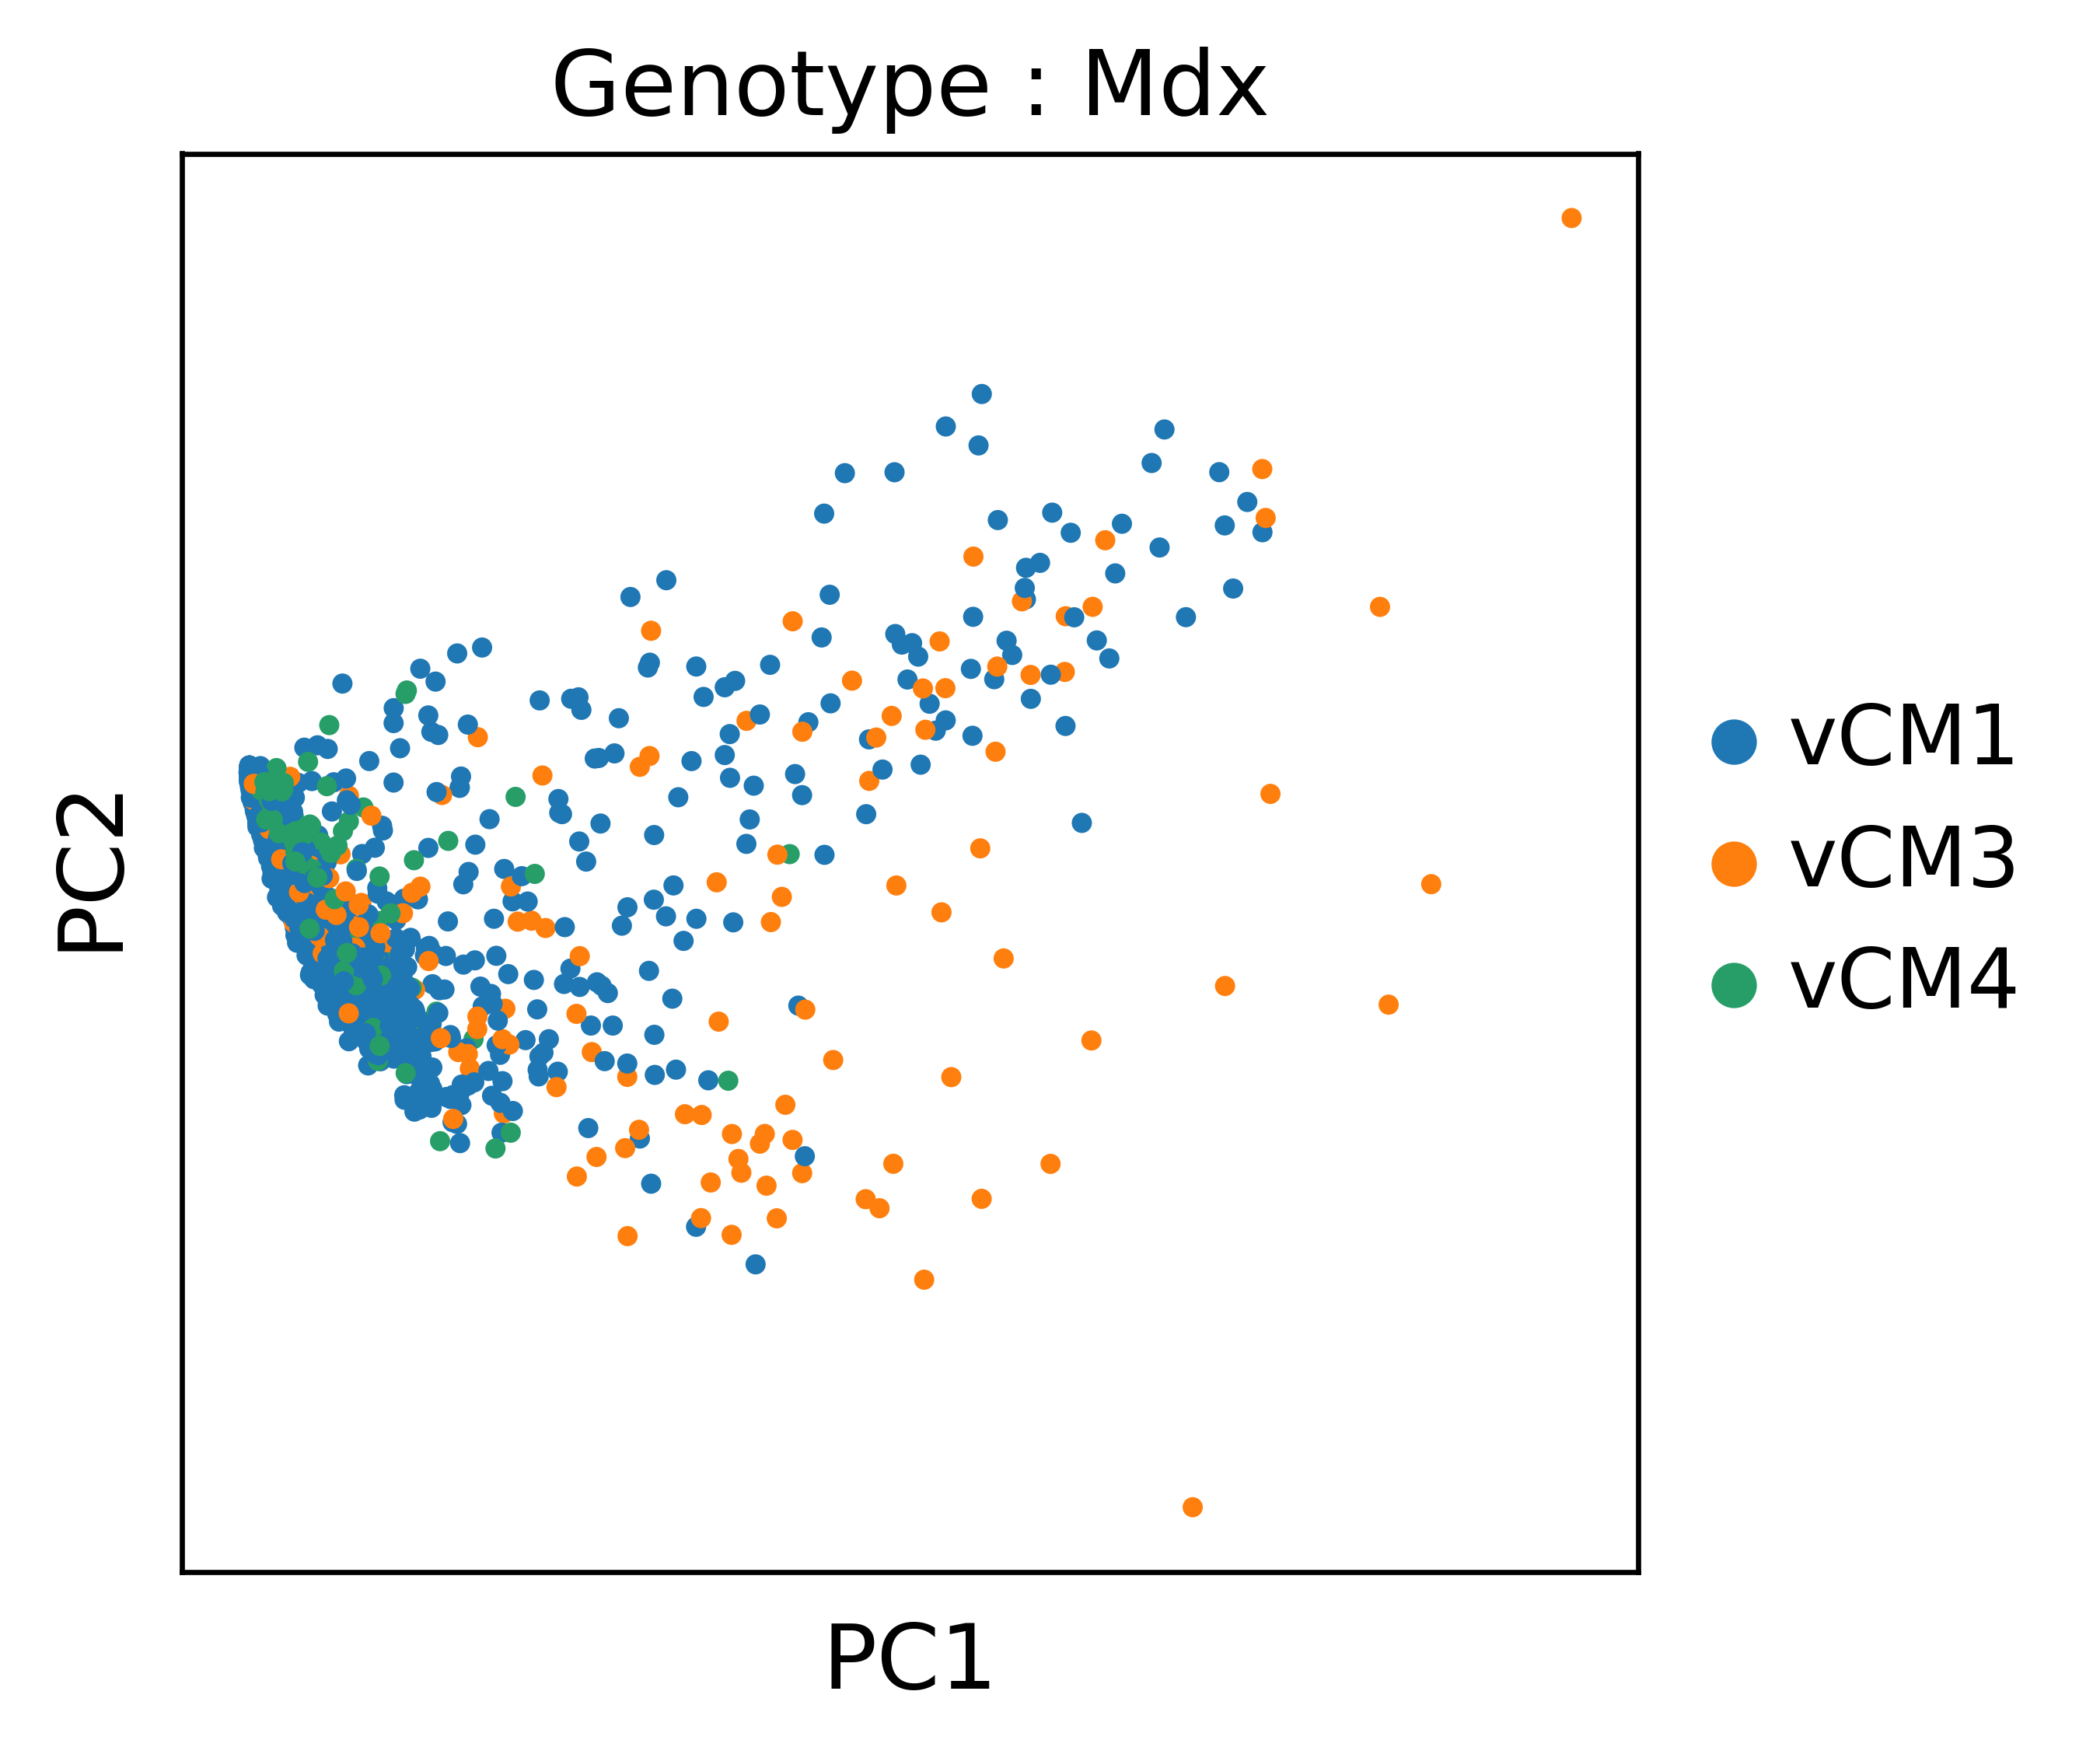

In [24]:
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata,svd_solver="arpack", use_highly_variable=True)
sc.pl.pca(adata, color= 'cell_state', title = 'Genotype : Mdx')